In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
import scipy

In [2]:
# set random seed for debugging purpose, need to turn off when perform monte carlo
# np.random.seed(42)

In [3]:
# plots
def gain(w):
    """Return the power as a function of azimuthal angle, phi."""
    phi = np.linspace(0, 2*np.pi, 1000)
    psi = 2*np.pi * 1 / 2 * np.cos(phi)
    j = np.arange(len(w))
    A = np.sum(w[j] * np.exp(j * 1j * psi[:, None]), axis=1)
    g = np.abs(A)**2
    return phi, g

def get_directive_gain(g, minDdBi=-20):
    """Return the "directive gain" of the antenna array producing gain g."""
    DdBi = 10 * np.log10(g / np.max(g))
    return np.clip(DdBi, minDdBi, None)

## channel generation

In [4]:
def rand_angles(M):
    return np.random.randint(0, 180, M)/180*np.pi # 0->180deg

def rand_distances(M):
    return np.random.randint(1000, 2500, M) # 50-250m

def generate_channels_LOS(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    r = np.arange(N)
    h_array_LOS = [np.exp(-2j*np.pi*distances[i]/lambda_)*np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]
    h_array_LOS_norm_QoS = []
    h_array_LOS_norm_MaxMin = []
    
    for i in range(M):
        # normalization QoS
        h_i_norm_QoS = h_array_LOS[i]/np.sqrt(rho_min_qos_sigma2)
        h_array_LOS_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_array_LOS[i]/sigma_i
        h_array_LOS_norm_MaxMin.append(h_i_norm_MaxMin)
    
    # generate H_i matrix
    H_array_LOS = []
    H_array_LOS_norm_QoS = []
    H_array_LOS_norm_MaxMin = []
    for i in range(M):
        H_array_LOS.append(np.matmul(h_array_LOS[i], np.conjugate(h_array_LOS[i]).T))
        H_array_LOS_norm_QoS.append(np.matmul(h_array_LOS_norm_QoS[i], np.conjugate(h_array_LOS_norm_QoS[i]).T))
        H_array_LOS_norm_MaxMin.append(np.matmul(h_array_LOS_norm_MaxMin[i], np.conjugate(h_array_LOS_norm_MaxMin[i]).T))
        
    return h_array_LOS, h_array_LOS_norm_QoS, h_array_LOS_norm_MaxMin, H_array_LOS, H_array_LOS_norm_QoS, H_array_LOS_norm_MaxMin
        
def generate_channels(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    # channel generation
    h_array = []
    h_array_norm_QoS = []
    h_array_norm_MaxMin = []
    for i in range(M):
        # complex normal with zero-mean, unit-variance
        # h_i = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(N, 2)).view(np.complex128)
        # h_i = np.exp(-2j*np.pi*distances[i]/lambda_)*(np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)))
        h_i = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain
        # h_i = (np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain and no scale var
        h_array.append(h_i)

        # normalization QoS
        h_i_norm_QoS = h_i/np.sqrt(rho_min_qos_sigma2)
        h_array_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_i/sigma_i
        h_array_norm_MaxMin.append(h_i_norm_MaxMin)

    # generate H_i matrix
    H_array = []
    H_array_norm_QoS = []
    H_array_norm_MaxMin = []
    for i in range(M):
        H_array.append(np.matmul(h_array[i], np.conjugate(h_array[i]).T))
        H_array_norm_QoS.append(np.matmul(h_array_norm_QoS[i], np.conjugate(h_array_norm_QoS[i]).T))
        H_array_norm_MaxMin.append(np.matmul(h_array_norm_MaxMin[i], np.conjugate(h_array_norm_MaxMin[i]).T))
        
    return h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin
    

## Randomization

In [117]:
e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))

In [118]:
e_js

array([[4.80416549],
       [5.25744268],
       [5.89825976],
       [1.03145347]])

In [119]:
e = np.cos(e_js) + 1j*np.sin(e_js)

In [121]:
e

array([[0.09164773-0.99579149j],
       [0.51846401-0.85509945j],
       [0.92682639-0.37549013j],
       [0.51357224+0.85804636j]])

In [120]:
np.sqrt(np.diag(np.diag(W_opt)))

array([[0.74067519+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.39679941+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.26412755+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.2129602 +0.j]])

In [122]:
np.matmul(np.sqrt(np.diag(np.diag(W_opt))), e)

array([[0.0678812 -0.73755806j],
       [0.20572621-0.33930296j],
       [0.24480038-0.09917729j],
       [0.10937045+0.18272972j]])

In [123]:
(0.09164773-0.99579149j)*0.74067519

(0.0678811998308187-0.7375580510561331j)

In [125]:
np.diag(W_opt)

array([0.54859974+0.j, 0.15744977+0.j, 0.06976336+0.j, 0.04535205+0.j])

In [126]:
np.multiply(e.ravel(), np.sqrt(np.diag(W_opt)))

array([0.0678812 -0.73755806j, 0.20572621-0.33930296j,
       0.24480038-0.09917729j, 0.10937045+0.18272972j])

In [53]:
def recover_w_SVD(W_opt):
    v, d = np.linalg.eig(W_opt)
    w_opt = d[:,0]
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randA(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randB(W_opt):
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    w_opt = np.matmul(np.sqrt(np.diag(np.diag(W_opt))), e)
    return w_opt.reshape((W_opt.shape[0], 1))
    
def recover_w_randC(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e = np.sqrt(2)/2*(np.random.randn(W_opt.shape[0]) + 1j*np.random.randn(W_opt.shape[0])).reshape((N, 1))
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))


## Check violation

In [27]:
def check_violation(w, h):
    scale_factor = 1
    constraint = np.abs(np.dot(np.conjugate(h).T, w))[0][0]**2
    # print(constraint)
    violate = constraint < 1
    if violate:
        return np.sqrt(1.0/constraint), constraint
    return scale_factor, constraint

def get_min_scale_factor(w, h_array):
    s = np.max(np.abs(np.matmul(np.conjugate(w).T, h_array)).ravel())
    if s > 1:
        return s
    return 1

def calc_norm2(w):
    # return np.sqrt(np.abs(np.dot(np.conjugate(w).T, w))[0][0])
    return np.linalg.norm(w)

def get_min_snr(w, h_array):
    min_snr = np.inf
    for h in h_array:
        snr = np.abs(np.dot(np.conjugate(h).T, w))**2
        # print(snr)
        min_snr = np.min([min_snr, snr])
    return min_snr

In [100]:
N = 4 # number of transmit antennas
M = 4 # number of mobile users
# P = 1 # transmit power

lambda_ = 0.375 # carrier wavelength
antenna_sep = 1/2 # antenanna separation half wavelength

# QoS
rho_min_qos_sigma2 = 1 #rho_min_i * sigma_i^2 = 1 for all i

# Max-Min
sigma_i = 1 

In [101]:
angles = rand_angles(M)
distances = rand_distances(M)

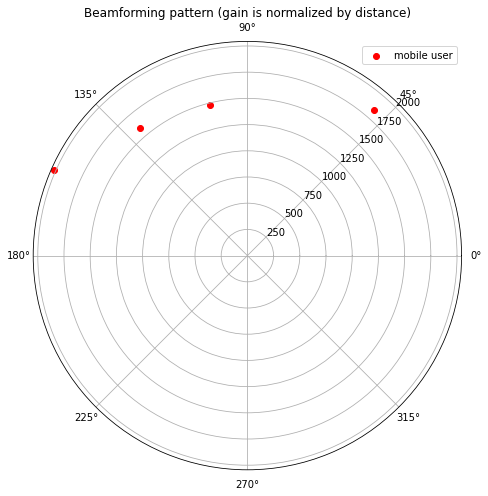

In [102]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern (gain is normalized by distance)")
plt.legend()
plt.tight_layout()
plt.show()

## Generate LoS channel

In [13]:
h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels_LOS(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1)

## QoS LoS sanity check

In [14]:
W = cp.Variable((N, N), hermitian=True)

# need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
constraints = [W >> 0]
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_QoS[i]))) >= 1 for i in range(M)]

prob = cp.Problem(cp.Minimize( cp.real(cp.trace(W))),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

# recover svd
w_SVD   = recover_w_SVD(W_opt)
scale_factor_SVD = get_min_scale_factor(w_SVD, H_array_norm_QoS)
w_SVD *= scale_factor_SVD
ubpb_SVD = np.linalg.norm(w_SVD)**2/opt
print("SVD upper bound power boost (dB) = ", ubpb_SVD)
ubpb = []

for i in range(1000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD), calc_norm2(w_randA), calc_norm2(w_randB), calc_norm2(w_randC)]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)/opt)
    
print("MC 1000 upper bound power boost (dB) = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

w_best = None
ubpb_best = np.inf

for i in range(30*N*M):
# for i in range(10000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA *= scale_factor_randA
    w_randB *= scale_factor_randB
    w_randC *= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD), calc_norm2(w_randA), calc_norm2(w_randB), calc_norm2(w_randC)]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)/opt)
    
    if ubpb[-1] < ubpb_best:
        w_best = w_min
        ubpb_best = ubpb[-1]
w_best_qos = w_best
print("MC 30*N*M=", 30*N*M, "upper bound power (dB) boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

optimal objective value =  0.7116642130682369
SVD upper bound power boost (dB) =  1.9817549844076645
MC 1000 upper bound power boost (dB) =  1.4447339288625258 mean =  1.6640565546178052 std =  0.02466894158924493
MC 30*N*M= 3840 upper bound power (dB) boost =  1.3274917820420986 mean =  1.6642541672417086 std =  0.0251464115508094


In [19]:
np.linalg.norm(w_min)

1.187579092722896

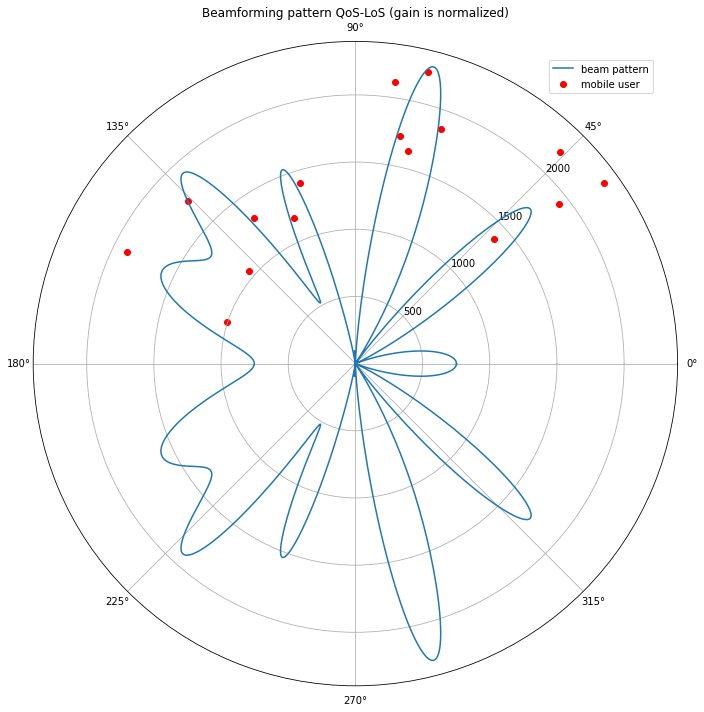

In [15]:
w = w_best_qos.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.max(distances)*np.log10(g)/np.log10(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern QoS-LoS (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()

plt.show()

In [23]:
# fig.savefig("figures/fig2_qos_los_{}user_{}an.png".format(M, N))

## MaxMin LoS sanity check

In [16]:
W = cp.Variable((N, N), hermitian=True)
t = cp.Variable(1)

constraints = [W >> 0]
constraints += [cp.real(cp.trace(W)) == 1] # power constraint
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

prob = cp.Problem(cp.Maximize(t),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

w_best_maxmin = None
max_minSNR = -np.inf
for i in tqdm.tqdm(range(30*N*M)):
# for i in tqdm.tqdm(range(5)):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    # scale to norm P
    w_randA /= np.linalg.norm(w_randA)
    w_randB /= np.linalg.norm(w_randB)
    w_randC /= np.linalg.norm(w_randC)

    w_l = [w_randA, w_randB, w_randC]
    minSNR = [np.min(abs(np.matmul(np.conjugate(w_randA).T, h_array_norm_MaxMin)).ravel()), 
              np.min(abs(np.matmul(np.conjugate(w_randB).T, h_array_norm_MaxMin)).ravel()), 
              np.min(abs(np.matmul(np.conjugate(w_randC).T, h_array_norm_MaxMin)).ravel())]

    w_best_tmp = w_l[np.argmax(minSNR)]
    max_minSNR_tmp = np.max(minSNR)
    
    if max_minSNR_tmp > max_minSNR:
        w_best_maxmin = w_best_tmp
        max_minSNR = max_minSNR_tmp
    
print("min SNR = ", t.value[0])
print("max_minSNR = ", max_minSNR**2)

optimal objective value =  1.4051570674331015


100%|█████████████████████████████████████| 3840/3840 [00:00<00:00, 4715.41it/s]

min SNR =  1.4051570674331015
max_minSNR =  1.1880361785005493


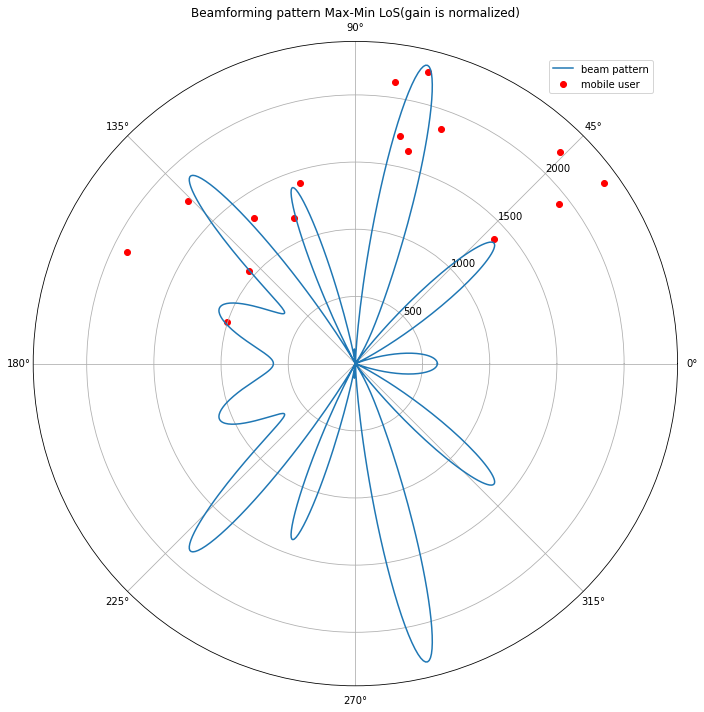

In [17]:
w = w_best_maxmin.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.log(g)*np.max(distances)/np.log(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern Max-Min LoS(gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [36]:
# fig.savefig("figures/fig5_maxmin_los_{}user_{}an.png".format(M, N))

## Plot both

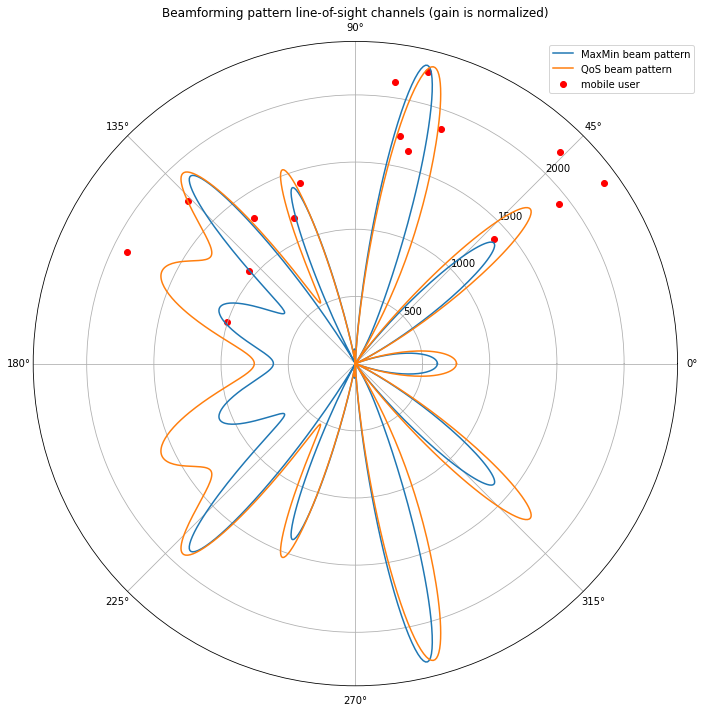

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")

# max min
w = w_best_maxmin.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="MaxMin beam pattern")

# QoS
w = w_best_qos.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="QoS beam pattern")

ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern line-of-sight channels (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [34]:
# fig.savefig("figures/fig6_qos_maxmin_los_{}user_{}an.png".format(M, N))

## Generate Rayleigh channel

In [103]:
h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels(angles, distances, lambda_, N, M, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)

## QoS formulation

In [104]:
W = cp.Variable((N, N), hermitian=True)

# need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
constraints = [W >> 0]
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_QoS[i]))) >= 1 for i in range(M)]

prob = cp.Problem(cp.Minimize( cp.real(cp.trace(W))),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

# recover svd
w_SVD   = recover_w_SVD(W_opt)
scale_factor_SVD = get_min_scale_factor(w_SVD, H_array_norm_QoS)
w_SVD *= scale_factor_SVD
ubpb_SVD = np.linalg.norm(w_SVD)**2/opt
print("SVD upper bound power boost = ", ubpb_SVD)
ubpb = []

for i in range(1000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA /= scale_factor_randA
    w_randB /= scale_factor_randB
    w_randC /= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD)**2, calc_norm2(w_randA)**2, calc_norm2(w_randB)**2, calc_norm2(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)**2/opt)
    
print("MC 1000 upper bound power boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

w_best = None
ubpb_best = np.inf

for i in range(30*N*M):
# for i in range(10000):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
    scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
    scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

    w_randA /= scale_factor_randA
    w_randB /= scale_factor_randB
    w_randC /= scale_factor_randC
    
    w_l = [w_SVD, w_randA, w_randB, w_randC]
    norm_l = [calc_norm2(w_SVD)**2, calc_norm2(w_randA)**2, calc_norm2(w_randB)**2, calc_norm2(w_randC)**2]

    w_min = w_l[np.argmin(norm_l)]
    ubpb.append(calc_norm2(w_min)**2/opt)
    
    if ubpb[-1] < ubpb_best:
        w_best = w_min
        ubpb_best = ubpb[-1]
w_best_qos = w_best
print("MC 30*N*M=", 30*N*M, "upper bound power boost = ", np.min(ubpb), "mean = ", np.mean(ubpb), "std = ", np.std(ubpb))

optimal objective value =  0.8211649218630024
SVD upper bound power boost =  4.279153657696496
MC 1000 upper bound power boost =  0.008741375901705139 mean =  0.4265604233670243 std =  0.2053563404822465
MC 30*N*M= 480 upper bound power boost =  0.008741375901705139 mean =  0.42284991294839536 std =  0.2022632530752255


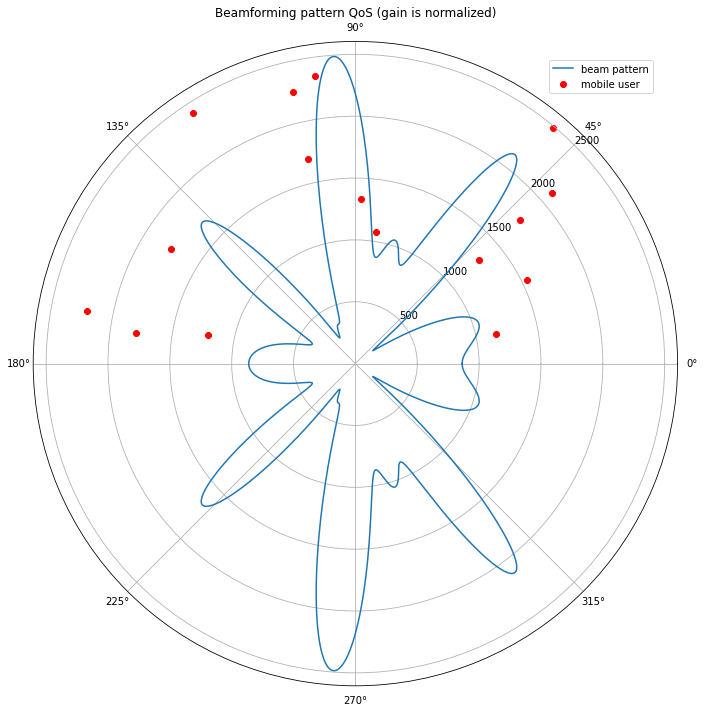

In [81]:
w = w_best_qos.ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.max(distances)*np.log10(g)/np.log10(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern QoS (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()

plt.show()

In [27]:
# fig.savefig("figures/fig3_qos_{}user_{}an.png".format(M, N))

## MaxMin formulation

In [82]:
W = cp.Variable((N, N), hermitian=True)
t = cp.Variable(1)

constraints = [W >> 0]
constraints += [cp.real(cp.trace(W)) == 1] # power constraint
constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

prob = cp.Problem(cp.Maximize(t),
             constraints)
opt = prob.solve(solver="MOSEK", verbose=False)
W_opt = W.value

print("optimal objective value = ", opt)
# print("optimal beamforming vector = ", W_opt)

w_best_maxmin = None
max_minSNR = -np.inf
for i in tqdm.tqdm(range(30*N*M)):
# for i in tqdm.tqdm(range(5)):
    # recover randomization
    w_randA = recover_w_randA(W_opt)
    w_randB = recover_w_randB(W_opt)
    w_randC = recover_w_randC(W_opt)

    # scale to norm P
    w_randA /= np.linalg.norm(w_randA)
    w_randB /= np.linalg.norm(w_randB)
    w_randC /= np.linalg.norm(w_randC)

    w_l = [w_randA, w_randB, w_randC]
    minSNR = [np.min(abs(np.matmul(np.conjugate(w_randA).T, h_array_norm_MaxMin)).ravel()), 
              np.min(abs(np.matmul(np.conjugate(w_randB).T, h_array_norm_MaxMin)).ravel()), 
              np.min(abs(np.matmul(np.conjugate(w_randC).T, h_array_norm_MaxMin)).ravel())]

    w_best_tmp = w_l[np.argmax(minSNR)]
    max_minSNR_tmp = np.max(minSNR)
    
    if max_minSNR_tmp > max_minSNR:
        w_best_maxmin = w_best_tmp
        max_minSNR = max_minSNR_tmp
    
print("min SNR = ", t.value[0])
print("max_minSNR = ", max_minSNR**2)


optimal objective value =  1.485176221198471


100%|█████████████████████████████████████| 3840/3840 [00:00<00:00, 4649.25it/s]

min SNR =  1.485176221198471
max_minSNR =  0.9283026619312442


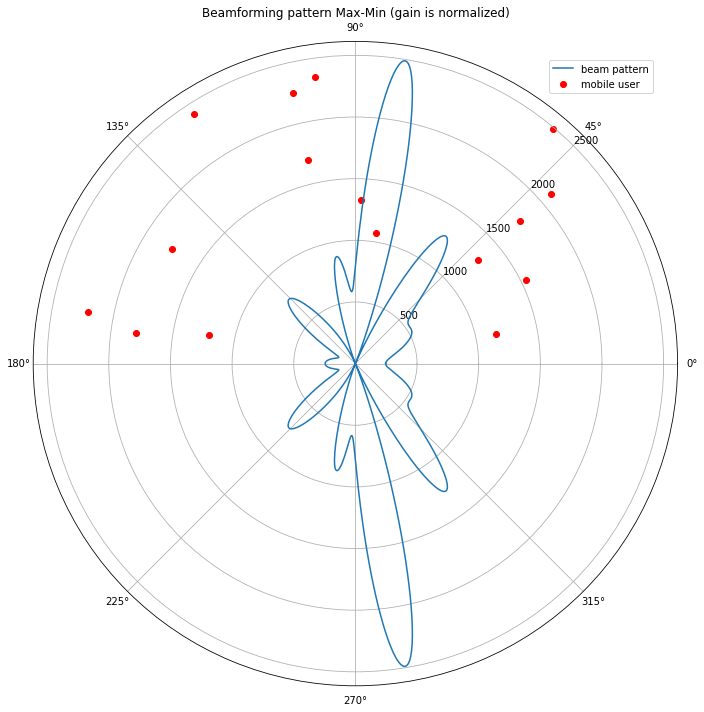

In [83]:
w = (w_best_maxmin/calc_norm2(w_best_maxmin)).ravel()
# Calculate gain and directive gain; plot on a polar chart.
phi, g = gain(w)
DdBi = get_directive_gain(g)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")
ax.plot(phi, g*np.max(distances)/np.max(g), label="beam pattern")
# ax.plot(phi, np.log(g)*np.max(distances)/np.log(np.max(g)), label="beam pattern")
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern Max-Min (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig("figures/fig4_maxmin_{}user_{}an.png".format(M, N))

## Plot both

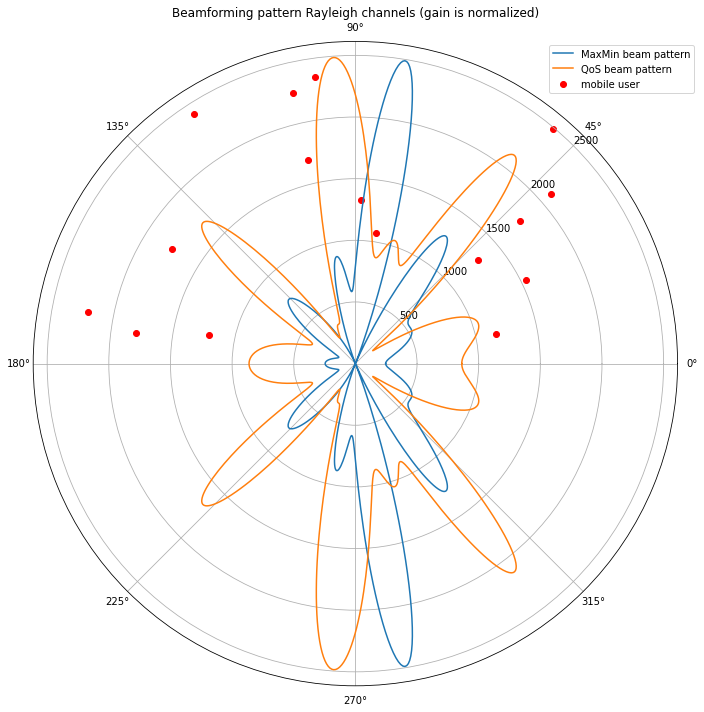

In [84]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar', label="meters")

# max min
w = w_best_maxmin.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="MaxMin beam pattern")

# QoS
w = w_best_qos.ravel()
phi, g = gain(w)
DdBi = get_directive_gain(g)
ax.plot(phi, g*np.max(distances)/np.max(g), label="QoS beam pattern")

ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern Rayleigh channels (gain is normalized)")
plt.legend()
ax.legend(loc=(0.8,0.92))
plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig("figures/fig7_qos_maxmin_rayleigh_{}user_{}an.png".format(M, N))

## MaxMin average calc

In [154]:
# QoS
rho_min_qos_sigma2 = 1 #rho_min_i * sigma_i^2 = 1 for all i

# Max-Min
sigma_i = 1 

# power
P = 1

In [155]:
N_list = [4, 4, 8, 8]
M_list = [8, 16, 16, 32]

In [ ]:
for N, M in zip(N_list, M_list):
    print("Solving N/M = {}/{}".format(N, M))

    best_t = []
    best_t_sdr = []
    best_t_avg = []
    no_bfm = []

    w_nobmf = (1/np.sqrt(N))*np.ones(N).reshape((N,-1))

    # Monte Carlo 1000 runs
    for k in tqdm.tqdm(range(1000)):
        # regenerate channel, no path loss
        h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels(None, None, lambda_, N, M, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)

        ### MAXMIN SDR ###
        W = cp.Variable((N, N), hermitian=True)
        t = cp.Variable(1)

        constraints = [W >> 0]
        constraints += [cp.real(cp.trace(W)) == P] # power constraint
        constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

        prob = cp.Problem(cp.Maximize(t),
                     constraints)
        opt = prob.solve(solver="MOSEK", verbose=False)
        W_opt = W.value

        best_t.append(t.value[0])
        
        max_minSNR = -np.inf
        for i in range(30*N*M):
            # recover randomization
            w_randA = recover_w_randA(W_opt)
            w_randB = recover_w_randB(W_opt)
            w_randC = recover_w_randC(W_opt)
            
            # scale to norm P
            w_randA /= np.linalg.norm(w_randA)/np.sqrt(P)
            w_randB /= np.linalg.norm(w_randB)/np.sqrt(P)
            w_randC /= np.linalg.norm(w_randC)/np.sqrt(P)

            max_minSNR_tmp = np.max([np.min(abs(np.matmul(np.conjugate(w_randA).T, h_array_norm_MaxMin)).ravel()),
                                    np.min(abs(np.matmul(np.conjugate(w_randB).T, h_array_norm_MaxMin)).ravel()),
                                    np.min(abs(np.matmul(np.conjugate(w_randC).T, h_array_norm_MaxMin)).ravel())
                                   ])
            max_minSNR = np.max([max_minSNR, max_minSNR_tmp])
        best_t_sdr.append(max_minSNR**2)
        ### END MAXMIN SDR ###

        ### MAX AVERAGE SDR ###
        W = cp.Variable((N, N), hermitian=True)

        constraints = [W >> 0]
        constraints += [cp.real(cp.trace(W)) == 1] # power constraint
        snr_list = [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) for i in range(M)]

        prob = cp.Problem(cp.Maximize(cp.sum(snr_list)),
                     constraints)
        opt = prob.solve(solver="MOSEK", verbose=False)
        W_opt = W.value
        
        best_t_avg.append(np.min([np.real(np.trace(np.matmul(W_opt, H_array_norm_MaxMin[i]))) for i in range(M)]))
        ### END AVERAGE SDR ###

        ### NO BEAMFORMING ###
        no_bfm.append(np.min(abs(np.matmul(np.conjugate(w_nobmf).T, h_array_norm_MaxMin)).ravel())**2)
        
    print("upper bound =", np.mean(best_t))
    print("sdr =", np.mean(best_t_sdr))
    print("avg =", np.mean(best_t_avg))
    print("no bmf =", np.mean(no_bfm))

    # format for latex copy paste
    print("{:.4f} & {:.4f} & {:.4f} & {:.4f}".format(np.mean(best_t), np.mean(best_t_sdr), np.mean(best_t_avg), np.mean(no_bfm)))
    print("\n\n")
    

Solving N/M = 4/8


100%|███████████████████████████████████████| 1000/1000 [03:32<00:00,  4.70it/s]


upper bound = 1.0247625653010455
sdr = 0.918491470581714
avg = 0.2423603989929873
no bmf = 0.12500335279508792
1.0248 & 0.9185 & 0.2424 & 0.1250



Solving N/M = 4/16


 30%|███████████▉                            | 299/1000 [02:01<04:46,  2.45it/s]

In [215]:
print("N/M = {}/{}".format(N, M))
print("upper bound =", np.mean(best_t))
print("sdr =", np.mean(best_t_sdr))
print("avg =", np.mean(best_t_avg))
print("no bmf =", np.mean(no_bfm))

# format for latex copy paste
print("{:.4f} & {:.4f} & {:.4f} & {:.4f}".format(np.mean(best_t), np.mean(best_t_sdr), np.mean(best_t_avg), np.mean(no_bfm)))

N/M = 8/32
upper bound = 1.0721142428106127
sdr = 0.09935714896700708
avg = 0.08114183204602293
no bmf = 0.03085893053123842
1.0721 & 0.0994 & 0.0811 & 0.0309


In [210]:
print("N/M = {}/{}".format(N, M))
print("upper bound =", np.mean(best_t))
print("sdr =", np.mean(best_t_sdr))
print("avg =", np.mean(best_t_avg))
print("no bmf =", np.mean(no_bfm))

# format for latex copy paste
print("{:.4f} & {:.4f} & {:.4f} & {:.4f}".format(np.mean(best_t), np.mean(best_t_sdr), np.mean(best_t_avg), np.mean(no_bfm)))

N/M = 4/8
upper bound = 1.044645311341831
sdr = 0.8488194761917104
avg = 0.3518028290060303
no bmf = 0.12193891263248482
1.0446 & 0.8488 & 0.3518 & 0.1219


In [201]:
print("N/M = {}/{}".format(N, M))
print("upper bound =", np.mean(best_t))
print("sdr =", np.mean(best_t_sdr))
print("avg =", np.mean(best_t_avg))
print("no bmf =", np.mean(no_bfm))

# format for latex copy paste
print("{:.4f} & {:.4f} & {:.4f} & {:.4f}".format(np.mean(best_t), np.mean(best_t_sdr), np.mean(best_t_avg), np.mean(no_bfm)))

N/M = 8/16
upper bound = 1.43417893929171
sdr = 0.328909709824828
avg = 0.2004431611362035
no bmf = 0.06295746400858589
1.4342 & 0.3289 & 0.2004 & 0.0630


In [196]:
print("N/M = {}/{}".format(N, M))
print("upper bound =", np.mean(best_t))
print("sdr =", np.mean(best_t_sdr))
print("avg =", np.mean(best_t_avg))
print("no bmf =", np.mean(no_bfm))

# format for latex copy paste
print("{:.4f} & {:.4f} & {:.4f} & {:.4f}".format(np.mean(best_t), np.mean(best_t_sdr), np.mean(best_t_avg), np.mean(no_bfm)))

N/M = 4/16
upper bound = 0.728529544975658
sdr = 0.2582557885099497
avg = 0.14531565443462446
no bmf = 0.06320614782240805
0.7285 & 0.2583 & 0.1453 & 0.0632


In [ ]:
0.8**2